# MNIST Digit Recognition - CNN

In [1]:
from __future__ import division, print_function
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

LOG_DIR = os.path.join(DATA_DIR, "tf-mnist-cnn-logs")
MODEL_FILE = os.path.join(DATA_DIR, "tf-mnist-cnn")

IMG_SIZE = 28
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 5

## Prepare Data

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        xdata.append(np.reshape(np.array([float(x) / 255. 
            for x in cols[1:]]), (IMG_SIZE, IMG_SIZE, 1)))
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    y = np.array(ydata)
    X = np.array(xdata)
    return X, y

Xtrain, ytrain = parse_file(TRAIN_FILE)
Xtest, ytest = parse_file(TEST_FILE)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [4]:
def datagen(X, y, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES):
    ohe = OneHotEncoder(n_values=num_classes)
    while True:
        shuffled_indices = np.random.permutation(np.arange(len(y)))
        num_batches = len(y) // batch_size
        for bid in range(num_batches):
            batch_indices = shuffled_indices[bid*batch_size:(bid+1)*batch_size]
            Xbatch = np.zeros((batch_size, X.shape[1], X.shape[2], X.shape[3]))
            Ybatch = np.zeros((batch_size, num_classes))
            for i in range(batch_size):
                Xbatch[i] = X[batch_indices[i]]
                Ybatch[i] = ohe.fit_transform(y[batch_indices[i]]).todense()
            yield Xbatch, Ybatch

self_test_gen = datagen(Xtrain, ytrain)
Xbatch, Ybatch = self_test_gen.next()
print(Xbatch.shape, Ybatch.shape)

(128, 28, 28, 1) (128, 10)


## Define Network

In [5]:
with tf.name_scope("data"):
    X = tf.placeholder(tf.float32, [None, IMG_SIZE, IMG_SIZE, 1], name="X")
    Y = tf.placeholder(tf.float32, [None, NUM_CLASSES], name="Y")

In [6]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding="SAME")
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding="SAME")

def network(x, dropout=0.75):
    # CONV-1: 5x5 kernel, channels 1 => 32
    W1 = tf.Variable(tf.random_normal([5, 5, 1, 32]))
    b1 = tf.Variable(tf.random_normal([32]))
    conv1 = conv2d(x, W1, b1)
    # MAXPOOL-1
    conv1 = maxpool2d(conv1, 2)
    # CONV-2: 5x5 kernel, channels 32 => 64
    W2 = tf.Variable(tf.random_normal([5, 5, 32, 64]))
    b2 = tf.Variable(tf.random_normal([64]))
    conv2 = conv2d(conv1, W2, b2)
    # MAXPOOL-2
    conv2 = maxpool2d(conv2, k=2)
    # FC1: input=(None, 7, 7, 64), output=(None, 1024)
    flatten = tf.reshape(conv2, [-1, 7*7*64])
    W3 = tf.Variable(tf.random_normal([7*7*64, 1024]))
    b3 = tf.Variable(tf.random_normal([1024]))
    fc1 = tf.add(tf.matmul(flatten, W3), b3)
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    # Output, class prediction (1024 => 10)
    W4 = tf.Variable(tf.random_normal([1024, NUM_CLASSES]))
    b4 = tf.Variable(tf.random_normal([NUM_CLASSES]))
    pred = tf.add(tf.matmul(fc1, W4), b4)
    return pred

# define network
Y_ = network(X, 0.75)

In [7]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=Y_, labels=Y))
optimizer = tf.train.AdamOptimizer(
    learning_rate=LEARNING_RATE).minimize(loss)

In [8]:
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [9]:
tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

## Train Network

In [10]:
history = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    # tensorboard viz
    logger = tf.summary.FileWriter(LOG_DIR, sess.graph)

    train_gen = datagen(Xtrain, ytrain, BATCH_SIZE)
    num_batches = len(Xtrain) // BATCH_SIZE
    for epoch in range(NUM_EPOCHS):
        total_loss, total_acc = 0., 0.
        for bid in range(num_batches):
            Xbatch, Ybatch = train_gen.next()
            _, batch_loss, batch_acc, Ybatch_, summary = sess.run(
                [optimizer, loss, accuracy, Y_, merged_summary_op], 
                feed_dict={X: Xbatch, Y:Ybatch}) 
            # write to tensorboard
            logger.add_summary(summary, epoch * num_batches + bid)
            # accumulate to print once per epoch
            total_acc += batch_acc
            total_loss += batch_loss

        total_acc /= num_batches
        total_loss /= num_batches
        print("Epoch {:d}/{:d}: loss={:.3f}, accuracy={:.3f}".format(
            (epoch + 1), NUM_EPOCHS, total_loss, total_acc))
        saver.save(sess, MODEL_FILE, (epoch + 1))
        history.append((total_loss, total_acc))

logger.close()

Epoch 1/5: loss=5584.093, accuracy=0.780
Epoch 2/5: loss=678.500, accuracy=0.929
Epoch 3/5: loss=356.641, accuracy=0.949
Epoch 4/5: loss=225.928, accuracy=0.960
Epoch 5/5: loss=158.486, accuracy=0.966


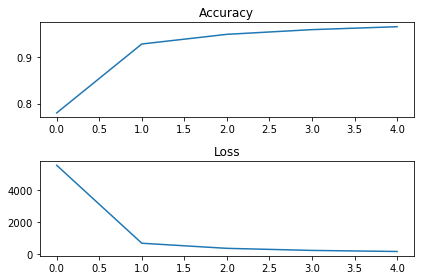

In [11]:
losses = [x[0] for x in history]
accs = [x[1] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs)

plt.subplot(212)
plt.title("Loss")
plt.plot(losses)

plt.tight_layout()
plt.show()

## Visualize with Tensorboard

We have also requested the total_loss and total_accuracy scalars to be logged in our computational graph, so the above charts can also be seen from the built-in tensorboard tool. The scalars are logged to the directory given by LOG_DIR, so we can start the tensorboard tool from the command line:

    $ cd ../../data
    $ tensorboard --logdir=tf-mnist-cnn-logs
    Starting TensorBoard 54 at http://localhost:6006
    (Press CTRL+C to quit)
    
We can then view the [visualizations on tensorboard] (http://localhost:6006)

## Evaluate Network

In [12]:
BEST_MODEL = os.path.join(DATA_DIR, "tf-mnist-cnn-5")
saver = tf.train.Saver()
ys, ys_ = [], []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, BEST_MODEL)
    test_gen = datagen(Xtest, ytest, BATCH_SIZE)
    val_loss, val_acc = 0., 0.
    num_batches = len(Xtrain) // BATCH_SIZE
    for _ in range(num_batches):
        Xbatch, Ybatch = test_gen.next()
        Ybatch_ = sess.run(Y_, feed_dict={X: Xbatch, Y:Ybatch})
        ys.extend(np.argmax(Ybatch, axis=1))
        ys_.extend(np.argmax(Ybatch_, axis=1))

acc = accuracy_score(ys_, ys)
cm = confusion_matrix(ys_, ys)
print("Accuracy: {:.4f}".format(acc))
print("Confusion Matrix")
print(cm)

INFO:tensorflow:Restoring parameters from ../../data/tf-mnist-cnn-5
Accuracy: 0.9639
Confusion Matrix
[[5753    1   28    9    8   12   70    5   33   23]
 [   3 6674   22    0    7    3   11   23    1   28]
 [  15   11 5934   31   13    0    8   92   31   20]
 [   7   20   47 5897    0   70    4   38   62   25]
 [   0   12   14    0 5685    0   11   16   18   93]
 [  12    4    2   27    5 5118   42    4   20   33]
 [  34   11   17    7   32   39 5543    0   19    5]
 [   7    4   46   24   17    8    0 5872   26   45]
 [  40   62   73   44   37   72   55   34 5586   93]
 [   4    2    2   13   79   17    0   66   35 5679]]
